# MNIST with Pytorch

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

Help from :
* https://nextjournal.com/gkoehler/pytorch-mnist
* https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558

In [1]:
# Automatically reload module
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [3]:
n_epochs = 2

## Data loading

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

* `__len__` so that `len(dataset)` returns the size of the dataset.
* `__getitem__` to support the indexing such that `dataset[i]` can be used to get ith sample

The data must be wrapped in a Dataset class. First the data must be wrapped in a Dataset class with a `getitem` method that from an index return `X_train[index]` and `y_train[index]` and a length method. A Dataset is basically a data storage. We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

In [4]:
from src.make_dataset import load_mnist

train_loader, test_loader = load_mnist('../data/mnist')

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

tensor(2)


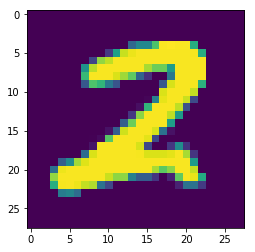

In [6]:
print(example_targets[0])
plt.imshow(example_data[0].view(28, 28).numpy())

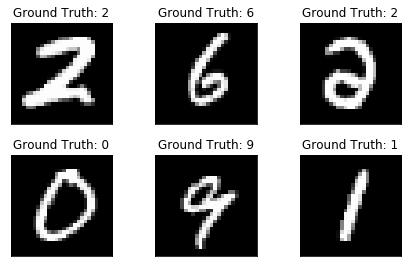

In [7]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].view(28, 28).numpy(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

## Multilayer Perceptron

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [9]:
mlp = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]  

In [10]:
for epoch in range(1, n_epochs + 1):
    # train step
    mlp.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # get the inputs
        data, target = Variable(data), Variable(target)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = mlp(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data.item()
            ))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
    # test step
    mlp.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = mlp(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [6336/60000 (11%)]	Loss: 0.227038
Train Epoch: 1 [12736/60000 (21%)]	Loss: 0.286926
Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.557149
Train Epoch: 1 [25536/60000 (43%)]	Loss: 0.392424
Train Epoch: 1 [31936/60000 (53%)]	Loss: 0.192840
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.094386
Train Epoch: 1 [44736/60000 (75%)]	Loss: 0.134074
Train Epoch: 1 [51136/60000 (85%)]	Loss: 0.165079
Train Epoch: 1 [57536/60000 (96%)]	Loss: 0.085353
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.231687

Test set: Avg. loss: 0.0001, Accuracy: 9612/10000 (96%)

Train Epoch: 2 [6336/60000 (11%)]	Loss: 0.081990
Train Epoch: 2 [12736/60000 (21%)]	Loss: 0.085127
Train Epoch: 2 [19136/60000 (32%)]	Loss: 0.082707
Train Epoch: 2 [25536/60000 (43%)]	Loss: 0.280259
Train Epoch: 2 [31936/60000 (53%)]	Loss: 0.141163
Train Epoch: 2 [38336/60000 (64%)]	Loss: 0.065283
Train Epoch: 2 [44736/60000 (75%)]	Loss: 0.099133
Train Epoch: 2 [51136/60000 (85%)]	Loss: 0.060310
Train Epoch: 2 [57536/60000 (96%)]	Loss: 0.

In [11]:
print(example_targets[0])
mlp(example_data[0])

tensor(2)


tensor([[-6.1427,  4.4398, 12.1404,  9.2255, -8.1886, -4.1806, -7.0414,  4.2259,
          3.6364, -6.7216]], grad_fn=<ThAddmmBackward>)

ValueError: x and y must be the same size

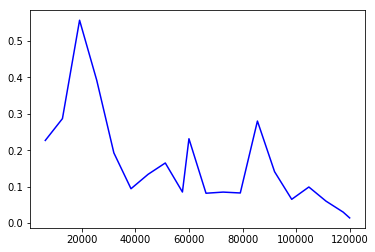

In [12]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

## ConvNet

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [15]:
conv_net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    conv_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # get the inputs
        data, target = Variable(data), Variable(target)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = conv_net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data.item()
            ))

C:\Utilisateurs\a557847\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305974
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.306440
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.308698
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.299999
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.309224
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.301967
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.306034
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.304241
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.303352
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.310185
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.302894
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.305111
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.304714
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.306016
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.302907
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.305307
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.303385
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.310153
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.306617
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.306948
Train Epoch: 0 [12800/60000 (